# Heart Disease Prediction using SciKit-Learn and Pandas

## Introduction

### Project Description

#### This project looks at several key health indicators to predict patient heart disease status. The model looks at features including blood pressure, age, glucose level, cholesterol, gender, and many others (see the linked dataset for more information). In this project, I performed exploratory data analysis, built several machine learning models in Sci Kit Learn, and evaluated them. These models include K Nearest Neighbors, Logistic Regression, Random Forest, and a Voting Classifier combining these 3 (more models may be added later). This project utilizes several packages, including Pandas for data processing, Sci Kit Learn for ML models, and a little Seaborn in combination with MatPlotLib for visualization. However, the vast majority of library use is Pandas and Sci Kit Learn.

### Further Resources and Dataset

#### Here is a link to a short description of the models used in this notebook that I wrote: https://docs.google.com/document/d/16NcIrCKdYEvDx1Z7Q63QNwTypqvZhy1UBmb9carvOxY/edit?usp=sharing

#### Dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Imports and data preparation

In [1]:
#Data preprocessing and preparation
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.impute import KNNImputer
import numpy as np

#Models
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Evaluation
from sklearn.model_selection import cross_val_score as cvs
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


#Optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
#Create dataframe, drop rows where Cholesterol is missing, get dummy variables and make a second dataframe with them
#Dataframe for visualization
heart=pd.read_csv('heart.csv')
heart=heart[heart.Cholesterol!=0]

#Dataframe for ML models. Dummies are for categorical variables.
heartWithDummies=pd.get_dummies(heart, drop_first=False)

#Convert first dataframe categorical variables to binary categories to allow for pivot table calculations
heart['Sex'].replace({'M':1, 'F':0}, inplace=True)
heart['ExerciseAngina'].replace({'Y':1, 'N':0}, inplace=True)

#Create variables to hold models, best models, scores, and best scores
bestAcc=0
bestROC_AUC=0
bestF=0
bestSingleAcc=0

bestAccModel=''
bestROCModel=''
bestFModel=''
bestSingleAccModel=''

cvScores=[]
models=[]
auc=[]
fScores=[]
accuracyScores=[]

#Display head of dataframe for reference
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


## Exploratory Data Analysis

### Correlation Summary

In [3]:
#Create pivot table based on heart disease status and other factors
pivot=heart.pivot_table(values=['Age', "Sex", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "ExerciseAngina","Oldpeak"],index='HeartDisease')

#Transform proportions into percentages
pivot.rename(columns={'FastingBS': 'Fasting Glucose Over 120 (%)', 'ExerciseAngina': 'Exercise Angina (%)','Sex': 'Male percent of sample (%)'}, inplace=True)

pivot['Fasting Glucose Over 120 (%)'] = pivot['Fasting Glucose Over 120 (%)']*100
pivot['Exercise Angina (%)'] = pivot['Exercise Angina (%)']*100
pivot['Male percent of sample (%)'] = pivot['Male percent of sample (%)']*100

pivot.rename(index={0:"No", 1:"Yes"}, inplace=True)

#Add caption and display pivot table
captioned = pivot.style.set_caption('Pivot Table for Heart Disease Occurence and Health Information (Averages)')
display(captioned)

,Age,Cholesterol,Exercise Angina (%),Fasting Glucose Over 120 (%),MaxHR,Oldpeak,RestingBP,Male percent of sample (%)
HeartDisease,,,,,,,,
No,50.171795,238.769231,12.820513,11.025641,149.058974,0.393846,130.164103,63.589744
Yes,55.851124,251.061798,66.573034,23.033708,130.550562,1.457865,136.154494,88.764045


<AxesSubplot:title={'center':'Health Factors by Heart Disease Status'}, xlabel='Had Heart Disease'>

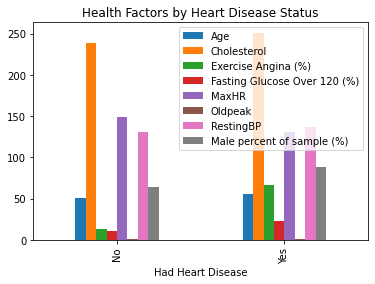

In [4]:
pivot.plot(kind='bar', title= "Health Factors by Heart Disease Status", xlabel='Had Heart Disease')

<AxesSubplot:>

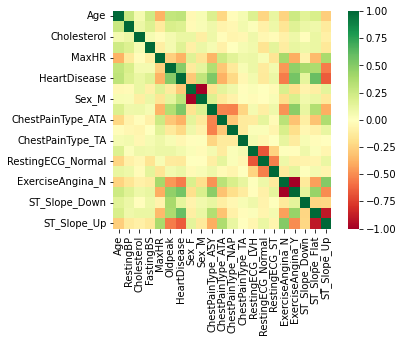

In [5]:
#Generate heatmap for correlation on dataframe, with dummy variables
sns.heatmap(heartWithDummies.corr(), square=True, cmap = 'RdYlGn')

<AxesSubplot:>

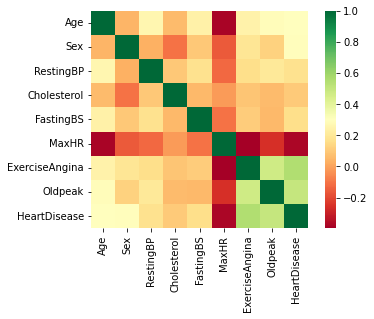

In [6]:
#Generate heatmap for correlation on dataframe, without dummy variables
sns.heatmap(heart.corr(), square=True, cmap = 'RdYlGn')

<AxesSubplot:title={'center':'Heart Indicators vs Age'}, xlabel='Age'>

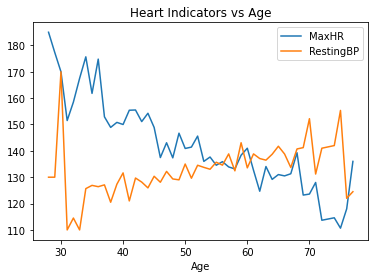

In [7]:
#Display a graph for factors based on heart disease presence

agePlot=heart.pivot_table(values=['MaxHR',  "RestingBP"],index='Age')
agePlot.plot(title='Heart Indicators vs Age')

<AxesSubplot:title={'center':'Peak vs Age'}, xlabel='Age'>

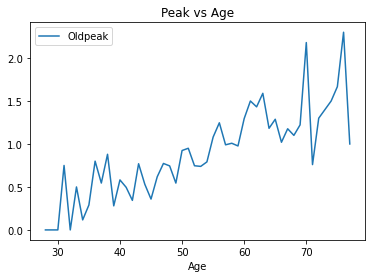

In [8]:
agePlot=heart.pivot_table(values=['Oldpeak'],index='Age')
agePlot.plot(title='Peak vs Age')

###  Numeric Data Summary

In [9]:
heart.describe().drop(columns=["Sex", "FastingBS", "ExerciseAngina", "HeartDisease"])

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609
std,9.505888,17.282750,59.153524,24.524107,1.072861
min,28.000000,92.000000,85.000000,69.000000,-0.100000
25%,46.000000,120.000000,207.250000,122.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000
75%,59.000000,140.000000,275.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>],
       [<AxesSubplot:title={'center':'Cholesterol'}>,
        <AxesSubplot:title={'center':'MaxHR'}>],
       [<AxesSubplot:title={'center':'Oldpeak'}>, <AxesSubplot:>]],
      dtype=object)

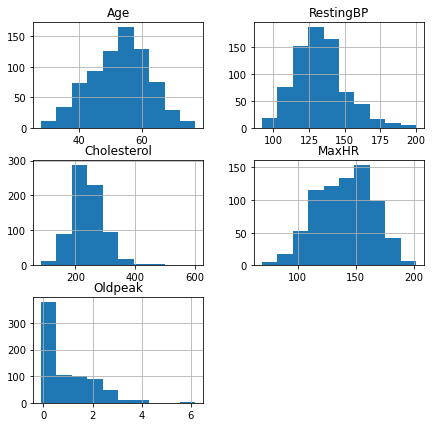

In [10]:
heart.hist(column=["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"], figsize=[7,7])

<AxesSubplot:>

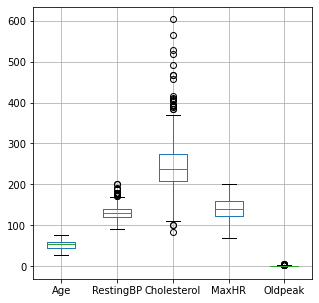

In [11]:
heart.boxplot(column=["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"], figsize=[5,5])

<AxesSubplot:>

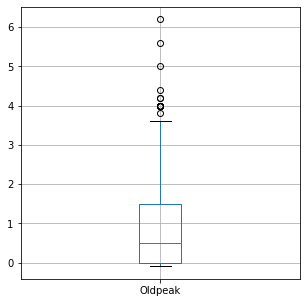

In [12]:
heart.boxplot(column=["Oldpeak"], figsize=[5,5])

### Categorical Data Summary

In [13]:
categorical=pd.read_csv('heart.csv')
categorical=categorical[categorical.Cholesterol!=0]
categorical=categorical[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease']]
categorical.FastingBS.replace({0:'Below 120',1:'Above 120'}, inplace=True)
categorical.HeartDisease.replace({0:'No disease',1:'Disease present'}, inplace=True)
categorical.describe()

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,746,746,746,746,746,746,746
unique,2,4,2,3,2,3,2
top,M,ASY,Below 120,Normal,N,Flat,No disease
freq,564,370,621,445,459,354,390


In [14]:
print('Unique values and counts for categorical columns:')
print('')
print(heart['ChestPainType'].value_counts())
print('_________________________________')
print(heart['ST_Slope'].value_counts())
print('________________________________')
print(heart['RestingECG'].value_counts())
print('________________________________')
print(heart['HeartDisease'].value_counts())
print('0 indicates not present, 1 indicates present')
print('________________________________')
print(heart['Sex'].value_counts())
print('1 indicates male, 0 female')
print('________________________________')
print(heart['ExerciseAngina'].value_counts())
print('0 indicates not present, 1 indicates present')
print('________________________________')
print(heart['FastingBS'].value_counts())
print('0 indicates below 120 mg/dL, 1 indicates above')
print('________________________________')


Unique values and counts for categorical columns:

ASY    370
NAP    169
ATA    166
TA      41
Name: ChestPainType, dtype: int64
_________________________________
Flat    354
Up      349
Down     43
Name: ST_Slope, dtype: int64
________________________________
Normal    445
LVH       176
ST        125
Name: RestingECG, dtype: int64
________________________________
0    390
1    356
Name: HeartDisease, dtype: int64
0 indicates not present, 1 indicates present
________________________________
1    564
0    182
Name: Sex, dtype: int64
1 indicates male, 0 female
________________________________
0    459
1    287
Name: ExerciseAngina, dtype: int64
0 indicates not present, 1 indicates present
________________________________
0    621
1    125
Name: FastingBS, dtype: int64
0 indicates below 120 mg/dL, 1 indicates above
________________________________


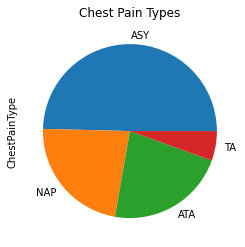

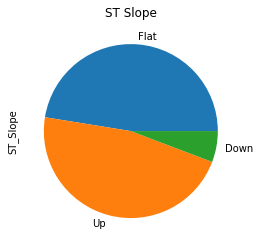

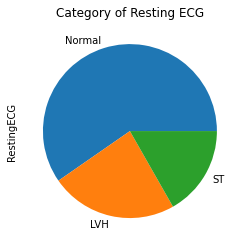

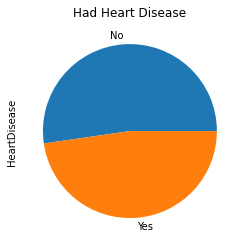

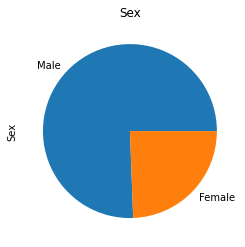

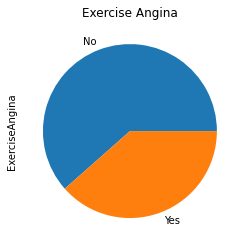

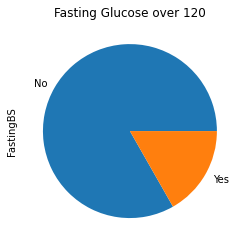

In [15]:
plt.figure(0)
heart['ChestPainType'].value_counts().plot(kind='pie', title='Chest Pain Types')
plt.figure(1)
heart['ST_Slope'].value_counts().plot(kind='pie', title= 'ST Slope')
plt.figure(2)
heart['RestingECG'].value_counts().plot(kind='pie', title='Category of Resting ECG')
plt.figure(3)
heart['HeartDisease'].value_counts().plot(kind='pie', title='Had Heart Disease', labels=["No","Yes"])
plt.figure(4)
heart['Sex'].value_counts().plot(kind='pie', title='Sex', labels=["Male","Female"])
plt.figure(5)
heart['ExerciseAngina'].value_counts().plot(kind='pie', title='Exercise Angina', labels=["No","Yes"])
plt.figure(6)
heart['FastingBS'].value_counts().plot(kind='pie', title='Fasting Glucose over 120', labels=["No","Yes"])

plt.show()


## Machine Learning Models

### ROC Graph and Calculation Function Definition

In [16]:
#Function to plot ROC Curve and print ROC Area Under Curve
def ROCCurve(model, xTest, yTest):
    y_pred_probabilities = model.predict_proba(xTest)[:,1]
    falsePos, truePos, thresholds = roc_curve(yTest, y_pred_probabilities)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Graph')
    plt.plot(falsePos, truePos)
    plt.show()
    
    print("ROC AUC SCORE: ",roc_auc_score(yTest, y_pred_probabilities))
    return roc_auc_score(yTest, y_pred_probabilities)

#Function to take mean of list
def mean(l):
    return sum(l)/len(l)   

### K Nearest Neighbor Classification

#### Building the model


In [17]:
#Base model off of scaled features, with dummy variables
unlabeledWithoutScale=heartWithDummies.drop(columns=['HeartDisease'])
labels=heartWithDummies['HeartDisease']

#Scale data
unlabeled = scale(unlabeledWithoutScale)


#Create train test split
xTrain, xTest, yTrain, yTest = train_test_split(unlabeled,labels,test_size=0.2, stratify=labels)

In [18]:
#Train KNNModel
KNNModel= KNeighborsClassifier(n_neighbors=25)
KNNModel.fit(xTrain,yTrain)

KNeighborsClassifier(n_neighbors=25)

#### Prediction and Evaluation

[[65 13]
 [11 61]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        78
           1       0.82      0.85      0.84        72

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



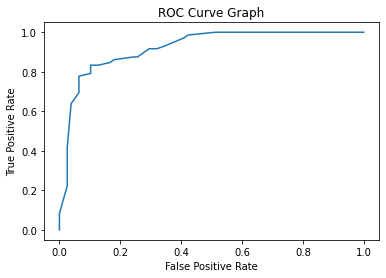

ROC AUC SCORE:  0.920940170940171


In [19]:
#Predict using KNN Model, create confusion matrix and classification report
KNNPredictions = KNNModel.predict(xTest)

#Print Confusion Matrix and Classification Report
print(confusion_matrix(y_pred=KNNPredictions,y_true=yTest))
print(classification_report(y_pred=KNNPredictions,y_true=yTest))

#Evaluate using cross validation, accuracy, F Score, and ROC evaluation
crossValidator=cvs(KNeighborsClassifier(n_neighbors=25), xTrain,yTrain, cv=10)
cvScoreKNN=crossValidator.mean()
accKNN=accuracy_score(y_true=yTest, y_pred=KNNPredictions)
fScoreKNN=f1_score(y_true=yTest, y_pred=KNNPredictions)
rocValKNN=ROCCurve(KNNModel, xTest, yTest)

In [20]:
#Add score results to score lists and note which model is best
cvScores.append(cvScoreKNN)
models.append('KNN')
fScores.append(fScoreKNN)
auc.append(rocValKNN)
accuracyScores.append(accKNN)

if cvScoreKNN>bestAcc:
    bestAccModel='KNN'
    bestAcc=cvScoreKNN
if fScoreKNN>bestF:
    bestFModel='KNN'
    bestF=fScoreKNN
if rocValKNN>bestROC_AUC:
    bestROCModel='KNN'
    bestROC_AUC=rocValKNN
if accKNN>bestSingleAcc:
    bestSingleAccModel='KNN'
    bestSingleAcc=accKNN

#### GridSearch Hypertuning

#Establish parameters and classifier
params={'n_neighbors': range(1,50,2)}
KNNNew=KNeighborsClassifier()

#Create grid search, fit it, and print best parameters
knnCV=GridSearchCV(KNNNew,params,cv=10)
knnCV.fit(xTrain, yTrain)
print(knnCV.best_params_)
print(knnCV.best_score_)

### Random Forest Model


#### Building Model

In [21]:
rfc=RandomForestClassifier(n_estimators=500, max_features='sqrt')
rfc.fit(xTrain, yTrain)

RandomForestClassifier(max_features='sqrt', n_estimators=500)

#### Predictions and Evaluation

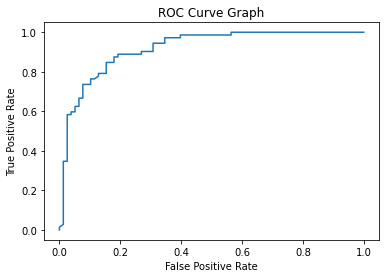

ROC AUC SCORE:  0.9177350427350427
[[62 16]
 [ 8 64]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        78
           1       0.80      0.89      0.84        72

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



In [22]:
#Predict on test set
predictionsRFC=rfc.predict(xTest)

#Calculate relevant statistics
accRFC=accuracy_score(yTest, predictionsRFC)
fScoreRFC=f1_score(yTest,predictionsRFC)
crossValidator=cvs(RandomForestClassifier(n_estimators=500, max_features='sqrt'), xTrain,yTrain, cv=10)
cvScoreRFC=crossValidator.mean()
rocValRFC=ROCCurve(rfc, xTest, yTest)

#Print confusion matrix and classification report
print(confusion_matrix(y_pred=predictionsRFC, y_true=yTest))
print(classification_report(y_pred=predictionsRFC, y_true=yTest))

In [23]:
#Add scores to scores list and note model performance
cvScores.append(cvScoreRFC)
models.append('RFC')
fScores.append(fScoreRFC)
auc.append(rocValRFC)
accuracyScores.append(accRFC)

if cvScoreRFC>bestAcc:
    bestAccModel='RFC'
    bestAcc=cvScoreRFC
if fScoreRFC>bestF:
    bestFModel='RFC'
    bestF=fScoreRFC
if rocValRFC>bestROC_AUC:
    bestROCModel='RFC'
    bestROC_AUC=rocValRFC
if accRFC>bestSingleAcc:
    bestSingleAccModel='RFC'
    bestSingleAcc=accRFC

#### Hyperparameter Tuning

max_features=[None, 'log2', 'sqrt']
max_depth=[None,100,500,1000]
min_samples_split=[2,5,10,15,20,25,30]
min_samples_leaf=[2,4,6,8,10]
n_estimators=[100,500,1000]

#Establish parameters and classifier
params={'max_depth':max_depth ,'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features, 'n_estimators':n_estimators}
NewRFC=RandomForestClassifier()

#Create grid search, fit it, and print best parameters
rfcCV=RandomizedSearchCV(NewRFC,params,cv=5, verbose=1)
rfcCV.fit(xTrain, yTrain)

print(rfcCV.best_params_)
print(rfcCV.best_score_)

#Note- the best parameters vary significantly for each trial, so I will continue to use the default

### Logistic Regression


#### Build Model

In [24]:
LRModel= LogisticRegression(max_iter=300)
LRModel.fit(xTrain, yTrain)

LogisticRegression(max_iter=300)

#### Prediction and Evaluation

[[61 17]
 [11 61]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        78
           1       0.78      0.85      0.81        72

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



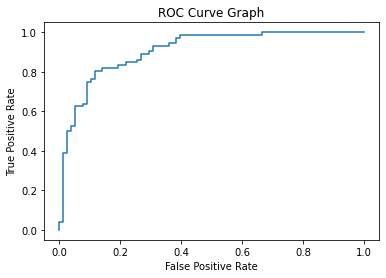

ROC AUC SCORE:  0.9075854700854701


In [25]:
#Predict on test set
predictions=LRModel.predict(xTest)

#Print confusion matrix, classification report, and calculate performance statistics
print(confusion_matrix(y_pred=predictions, y_true=yTest))
print(classification_report(y_pred=predictions, y_true=yTest))
crossValidator=cvs(LogisticRegression(max_iter=300), xTrain,yTrain, cv=10)
cvScoreLR=crossValidator.mean()
fScoreLR=f1_score(yTest, predictions)
accLR=accuracy_score(yTest, predictions)
rocValLR=ROCCurve(LRModel, xTest, yTest)

In [26]:
#Add scores to scores list and note model performance
cvScores.append(cvScoreLR)
models.append('LR')
fScores.append(fScoreLR)
auc.append(rocValLR)
accuracyScores.append(accLR)

if cvScoreLR>bestAcc:
    bestAccModel='LR'
    bestAcc=cvScoreLR
if fScoreLR>bestF:
    bestFModel='LR'
    bestF=fScoreLR
if rocValLR>bestROC_AUC:
    bestROCModel='LR'
    bestROC_AUC=rocValLR
if accLR>bestSingleAcc:
    bestSingleAccModel='LR'
    bestSingleAcc=accLR

#### Hyperparameter Tuning

C=[0.01,0.1,1,10,100]
penalty=['l2']
solver=['lbfgs','newton-cg','sag','saga']
params={'C':C, 'penalty':penalty, 'solver':solver}

LRModelNew= LogisticRegression(max_iter=1000000)
LRCV= GridSearchCV(LRModelNew, params, cv=10)

LRCV.fit(xTrain, yTrain)
print(LRCV.best_params_)
print(LRCV.best_score_)

### HistGradientBoosting Classifier

#### Build Model

#Create new dataframe with categorical variables encoded properly
heartx=pd.read_csv('heart.csv')
heartx=heart[heart.Cholesterol!=0].copy()
heartx['ST_Slope'].replace({'Up':1, 'Flat':0, 'Down':2}, inplace=True)
heartx['RestingECG'].replace({'Normal':1, 'LVH':0, 'ST':2}, inplace=True)
heartx['ChestPainType'].replace({'ASY':0, 'NAP':1, 'ATA':2, "TA":3}, inplace=True)

#Create train test split
unlabeled=heartx.drop(columns=['HeartDisease'])
labeled=heartx.HeartDisease
xTrain, xTest, yTrain, yTest = train_test_split(unlabeled,labeled,test_size=0.2, stratify=labels)

#Build and train model, and make predictions
model=HistGradientBoostingClassifier(categorical_features=[False, True,True,False,False,True,True,False,True,False,True])
model.fit(xTrain, yTrain)

#### Prediction and Evaluation

#Make predictions
pred=model.predict(xTest)

#Print confusion matrix, classification report, and get score statistics
print(confusion_matrix(y_pred=pred, y_true=yTest))
print(classification_report(y_pred=pred, y_true=yTest))

model2=HistGradientBoostingClassifier(categorical_features=[False, True,True,False,False,True,True,False,True,False,True])
crossValidator=cvs(model2, xTrain,yTrain, cv=10)
cvScoreHist=crossValidator.mean()
fScoreHist=f1_score(yTest, pred)
accHist=accuracy_score(yTest, pred)
rocValHist=ROCCurve(model, xTest, yTest)

cvScores.append(cvScoreHist)
models.append('Hist')
fScores.append(fScoreHist)
auc.append(rocValHist)
accuracyScores.append(accHist)

#Note model performance in comparison to others
if cvScoreHist>bestAcc:
    bestAccModel='Hist'
    bestAcc=cvScoreHist
if fScoreHist>bestF:
    bestFModel='Hist'
    bestF=fScoreHist
if rocValHist>bestROC_AUC:
    bestROCModel='Hist'
    bestROC_AUC=rocValHist
if accHist>bestSingleAcc:
    bestSingleAccModel='Hist'
    bestSingleAcc=accHist


### Combination of Models


#### Build Model

In [27]:
#Create ensemble model
KNNModel= KNeighborsClassifier(n_neighbors=25)

rfc=RandomForestClassifier(n_estimators=400)

LRModel= LogisticRegression(max_iter=5000)

combo = VotingClassifier(estimators=[('KN', KNNModel), ('RF', rfc), ('LR', LRModel)],
                        voting='soft',
                        weights=[1, 2, 1])

#Fit model
combo.fit(xTrain,yTrain)

VotingClassifier(estimators=[('KN', KNeighborsClassifier(n_neighbors=25)),
                             ('RF', RandomForestClassifier(n_estimators=400)),
                             ('LR', LogisticRegression(max_iter=5000))],
                 voting='soft', weights=[1, 2, 1])

#### Prediction and Evaluation

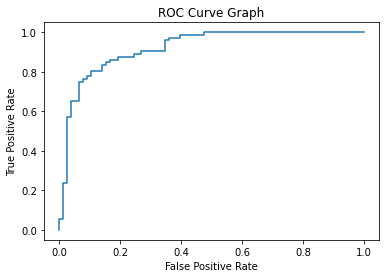

ROC AUC SCORE:  0.9200498575498576
[[61 17]
 [11 61]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        78
           1       0.78      0.85      0.81        72

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



In [28]:
#Make predictions
comboPredictions=combo.predict(xTest)

#Get model scores
crossValidator=cvs(VotingClassifier(estimators=[('KN', KNNModel), ('RF', rfc), ('LR', LRModel)], voting='soft',weights=[1, 2, 1]), xTrain,yTrain, cv=10)
cvScoreE=crossValidator.mean()
fScoreE=f1_score(yTest, comboPredictions)
accE=accuracy_score(yTest, comboPredictions)
rocValE=ROCCurve(combo, xTest, yTest)

#Print confusion matrix and classification report
print(confusion_matrix(y_pred=predictions, y_true=yTest))
print(classification_report(y_pred=predictions, y_true=yTest))

In [29]:
#Add scores to score lists
cvScores.append(cvScoreE)
models.append('Ensemble')
fScores.append(fScoreE)
auc.append(rocValE)
accuracyScores.append(accE)

#Note model performance compared to others
if cvScoreE>bestAcc:
    bestAccModel='Ensemble'
if fScoreE>bestF:
    bestFModel='Ensemble'
if rocValE>bestROC_AUC:
    bestROCModel='Ensemble'
if accE>bestSingleAcc:
    bestSingleAccModel='Ensemble'


#### Hyperparameter Tuning

params={'voting':['hard','soft'], 'weights':[(1,1,1),(1,1,2),(1,2,1),(2,1,1), (2,2,1), (2,1,2), (1,2,2), (2,3,2), (3,4,3)]}
KNNModel= KNeighborsClassifier(n_neighbors=30)

rfc=RandomForestClassifier(n_estimators=400)

LRModel= LogisticRegression(max_iter=1000)

comboNew = VotingClassifier(estimators=[('KN', KNNModel), ('RF', rfc), ('LR', LRModel)])


#Create grid search, fit it, and print best parameters
comboNewCV=GridSearchCV(comboNew,params,cv=5, verbose=1)
comboNewCV.fit(xTrain, yTrain)

print(comboNewCV.best_params_)
print(comboNewCV.best_score_)

## Model Comparison

### Graphical Comparison

<AxesSubplot:title={'center':'Model Comparison'}, xlabel='Models'>

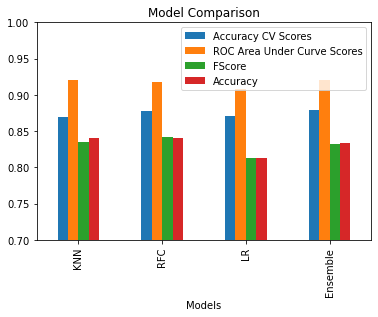

In [30]:
#Plot model comparison by average accuracy across K fold cross validation trials
df=pd.DataFrame()
df['Models']=models
df['Accuracy CV Scores']=cvScores
df['ROC Area Under Curve Scores']=auc
df['FScore']=fScores
df['Accuracy']=accuracyScores


df=df.set_index('Models')
df.plot(kind='bar', ylim=(.70,1), title='Model Comparison')

<AxesSubplot:title={'center':'Model Comparison by Averaged Accuracy'}, xlabel='Models'>

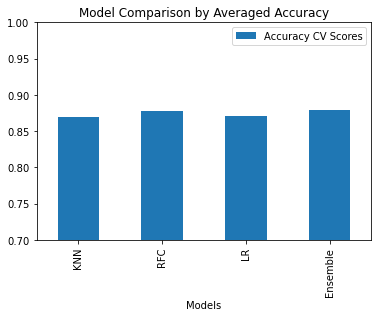

In [31]:
#Plot model comparison by average accuracy across K fold cross validation trials
df=pd.DataFrame()
df['Models']=models
df['Accuracy CV Scores']=cvScores


df=df.set_index('Models')
df.plot(kind='bar', ylim=(.70,1), title='Model Comparison by Averaged Accuracy')

<AxesSubplot:title={'center':'Model Comparison by ROC Area Under Curve Scores'}, xlabel='Models'>

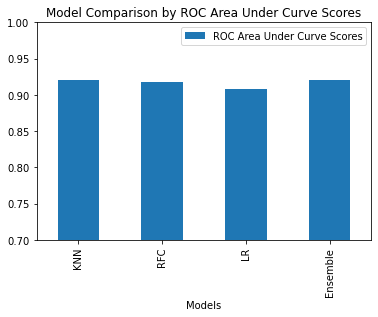

In [32]:
#Plot model comparison by ROC area under curve
df=pd.DataFrame()
df['Models']=models
df['ROC Area Under Curve Scores']=auc
df=df.set_index('Models')
df.plot(kind='bar', ylim=(.70,1), title='Model Comparison by ROC Area Under Curve Scores')

<AxesSubplot:title={'center':'Model Comparison by F Scores'}, xlabel='Models'>

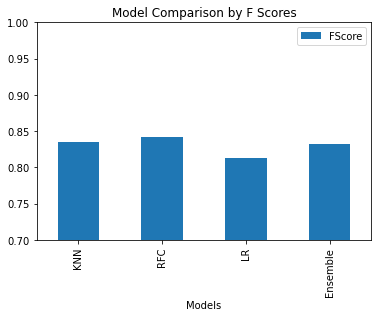

In [33]:
#Plot model comparison by F1 Scores
df=pd.DataFrame()
df['Models']=models
df['FScore']=fScores
df=df.set_index('Models')
df.plot(kind='bar', ylim=(.70,1), title='Model Comparison by F Scores')

<AxesSubplot:title={'center':'Model Comparison by Single Accuracy'}, xlabel='Models'>

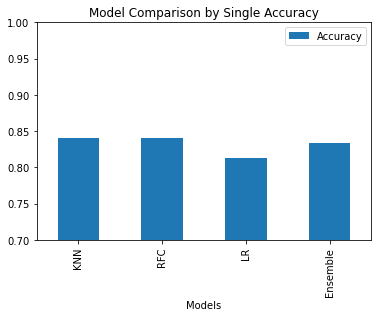

In [34]:
#Plot model comparison by single accuracy measurement
df=pd.DataFrame()
df['Models']=models
df['Accuracy']=accuracyScores
df=df.set_index('Models')
df.plot(kind='bar', ylim=(.70,1), title='Model Comparison by Single Accuracy')

### Numeric Summary

In [35]:
#Print performance, statistics, and best models by different evaluations
print("Models")
print(models)
print("CV Accuracy")
print(cvScores)
print("ROC AUC")
print(auc)
print("F Score")
print(fScores)
print("Single Accuracy")
print(accuracyScores)
print("______________________________________________________________________")
print("Most Accurate Model: " + bestAccModel)
print("Best Accuracy Score from Cross Validation: " , max(cvScores))
print("Best ROC AUC Model: " + bestROCModel)
print("Best ROC Score from Cross Validation: " , max(auc))
print("Best F Score Model: " + bestFModel)
print("Best F Score from Cross Validation: " , max(fScores))
print("Best Single Accuracy Model: " + bestSingleAccModel)
print("Best Single Accuracy: " , max(accuracyScores))

Models
['KNN', 'RFC', 'LR', 'Ensemble']
CV Accuracy
[0.8691807909604521, 0.8775423728813561, 0.8709039548022599, 0.8792090395480227]
ROC AUC
[0.920940170940171, 0.9177350427350427, 0.9075854700854701, 0.9200498575498576]
F Score
[0.8356164383561645, 0.8421052631578948, 0.8133333333333332, 0.8322147651006712]
Single Accuracy
[0.84, 0.84, 0.8133333333333334, 0.8333333333333334]
______________________________________________________________________
Most Accurate Model: Ensemble
Best Accuracy Score from Cross Validation:  0.8792090395480227
Best ROC AUC Model: KNN
Best ROC Score from Cross Validation:  0.920940170940171
Best F Score Model: RFC
Best F Score from Cross Validation:  0.8421052631578948
Best Single Accuracy Model: KNN
Best Single Accuracy:  0.84


In [36]:
#Uncomment for simple print of max scores

#print(max(cvScores))
#print(max(auc))
#print(max(fScores))
#print(max(accuracyScores))

In [37]:
#Print mean of various model statistics
print("CV Accuracy Mean")
print(mean(cvScores))
print()
print("ROC AUC Mean")
print(mean(auc))
print()
print("F Score Mean")
print(mean(fScores))
print()
print("Single Accuracy Mean")
print(mean(accuracyScores))

CV Accuracy Mean
0.8742090395480226

ROC AUC Mean
0.9165776353276354

F Score Mean
0.830817449987016

Single Accuracy Mean
0.8316666666666667
